In [1]:
import os

if "src" not in os.listdir():
    os.chdir("../../../")

import json
from datetime import timedelta
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pickle

import keras.backend as K
from keras import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.optimizers import Adam

%load_ext autoreload
%autoreload 2

from src.lib.stock_dataset import read_stock_dataset
from src.lib.activations import negative_softmax
from src.lib.losses import negative_profit_loss, multi_negative_sharpe_ratio_loss
from src.lib.util import makedir_to

In [2]:
symbols = ["SPY", "SPXS"]
n_time_steps = 64
batch_size = 256
epochs = 5
learning_rate = 0.0003
target_column = "oc_ret"

In [3]:
dataset = read_stock_dataset(symbols, target_column, n_time_steps)
train, valid, test, scaler = dataset.train_valid_test_split(timedelta(days=30), timedelta(days=0), scaled=True)
n_features = train.n_features
n_symbols = train.n_symbols
print(f"Loaded {len(train)} training, {len(valid)}, validation, and {len(test)} testing samples")
print(f"{n_features} features")
print(f"{n_symbols} targets")

Loaded 559016 training, 8191, validation, and 1 testing samples
26 features
2 targets


In [4]:
def build_model():
    target_tensor = Input((n_symbols,))
    input_tensor = Input((n_time_steps, n_features))
    z = input_tensor
    lstm_out = LSTM(64)(z)

    z = Dropout(0.25)(lstm_out)
    z = Dense(64, activation="selu")(z)
    z = Dropout(0.1)(z)
    holdings = Dense(n_symbols, activation=negative_softmax, name="holdings")(z)
    
    z = Dropout(0.25)(lstm_out)
    z = Dense(64, activation="selu")(z)
    z = Dropout(0.1)(z)
    p_invest = Dense(1, activation="sigmoid", name="p_invest")(z)

    model = Model([input_tensor, target_tensor], [holdings, p_invest])

    sharpe_loss = multi_negative_sharpe_ratio_loss(target_tensor, holdings)
    model.add_loss(sharpe_loss)

    adj_holdings = holdings * p_invest
    neg_adj_profit = K.sum(negative_profit_loss(target_tensor, adj_holdings), axis=-1)

    model.add_loss(neg_adj_profit)

    model.compile(Adam(lr=learning_rate))

    pred_model = Model(input_tensor, adj_holdings)

    return model, pred_model

In [5]:
train_batchable_index = train.get_batchable_index(trade_market_open=True)
n_iter_per_epoch = len(train_batchable_index)//batch_size

loss_history = []

model, pred_model = build_model()
valid_batchable_index = valid.get_batchable_index(trade_market_open=True)
X_batch_valid, y_batch_valid = valid.get_batch(len(valid_batchable_index), valid_batchable_index, replace=False, shuffle=False)

for epoch in range(epochs):
    pbar = tqdm(range(n_iter_per_epoch))
    for i in pbar:
        X_batch, y_batch = train.get_batch(batch_size, train_batchable_index)
        loss = model.train_on_batch([X_batch, y_batch])
        loss_history.append(loss)

        if len(loss_history) > 150:
            avg_loss = np.mean(loss_history[-150:])
        else:
            avg_loss = np.mean(loss_history)
        
        pbar.set_description("sharpe=%.3f" % -avg_loss)
    
    
    losses_valid = model.evaluate([X_batch_valid, y_batch_valid])
    avg_loss_valid = np.mean(losses_valid)


    print("Valid Sharpe:", -avg_loss_valid)

  0%|          | 0/2183 [00:00<?, ?it/s]2021-09-18 23:33:07.280210: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-18 23:33:07.281893: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz
sharpe=0.051: 100%|██████████| 2183/2183 [01:10<00:00, 30.82it/s]


254/254 [==============================] - 0s 2ms/step - loss: -0.0446
Valid Sharpe: 0.044629331678152084


sharpe=0.043: 100%|██████████| 2183/2183 [01:10<00:00, 31.02it/s]


254/254 [==============================] - 0s 1ms/step - loss: -0.0444
Valid Sharpe: 0.044408559799194336


sharpe=0.053: 100%|██████████| 2183/2183 [01:09<00:00, 31.43it/s]


254/254 [==============================] - 0s 1ms/step - loss: -0.0469
Valid Sharpe: 0.046896692365407944


sharpe=0.055: 100%|██████████| 2183/2183 [01:09<00:00, 31.30it/s]


254/254 [==============================] - 0s 1ms/step - loss: -0.0469
Valid Sharpe: 0.04691805690526962


sharpe=0.052: 100%|██████████| 2183/2183 [01:10<00:00, 30.97it/s]


254/254 [==============================] - 0s 1ms/step - loss: -0.0556
Valid Sharpe: 0.0555596761405468


SPY


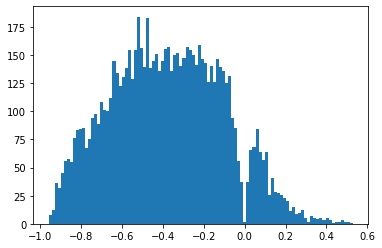

SPXS


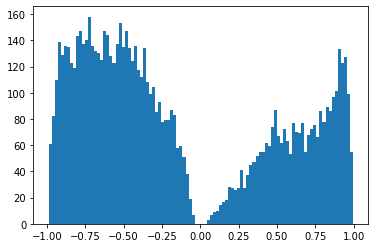

Allocation


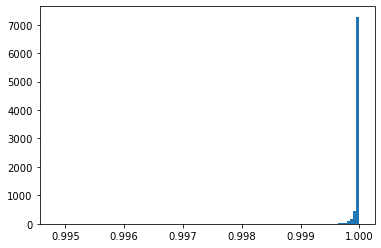

In [6]:
preds = pred_model.predict(X_batch_valid)
for i, symbol in enumerate(symbols):
    print(symbol)
    plt.hist(preds[:, i], bins=100)
    plt.show()

print("Allocation")
plt.hist(np.abs(preds).sum(-1), bins=100)
plt.show()

In [7]:
x = preds[:, 0]
y = preds[:, 1]

heatmap, xedges, yedges = np.histogram2d(x, y, bins=256)
# heatmap = np.log(heatmap+1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig = go.Figure()
fig.add_trace(go.Heatmap(z=heatmap.T))
fig.show()

In [8]:
rets = np.exp((np.log(preds * y_batch_valid+1)).sum(axis=-1).cumsum())
# rets = ((np.log(preds * y_batch_valid+1)).sum(axis=-1).cumsum())
fig = go.Figure()
fig.add_trace(go.Scatter(x=valid.index, y=rets))
fig.show()

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=valid.index, y=preds[:, 0], name=symbols[0]))
fig.add_trace(go.Scatter(x=valid.index, y=preds[:, 1], name=symbols[1]))
fig.show()

In [10]:
name = "1_lstm_ptrade"

config = {
    "name": name,
    "symbols": symbols,
    "n_time_steps": n_time_steps,
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
    "target_column": target_column
}

path = os.path.join("results", name)
makedir_to(os.path.join(path, "file.doesnotexist"))

with open(os.path.join(path, "config.json"), "w") as f:
    json.dump(config, f)

with open(os.path.join(path, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

pred_model.compile()
pred_model.save(os.path.join(path, "model.h5"))